**IMPORTA AS BIBLIOTECAS**

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from scipy.stats import beta


**LEITURA DOS ARQUIVOS**

In [17]:
class Struct:
    pass

def wrap_struct(solution):
    x = Struct()
    x.solution = solution
    return x

path_equip = 'Dados/EquipDB.csv'
path_planos = 'Dados/MPDB.csv'
path_cluster = 'Dados/ClusterDB.csv'

Equipamentos = pd.read_csv(path_equip, header=None, names=["ID", "t0", "cluster", "custo de falha"])
Planos = pd.read_csv(path_planos, header=None, names=["ID", "k", "custo"])
ModeloFalha = pd.read_csv(path_cluster, header=None, names=["ID", "eta", "beta"])

# Estrutura de dados
def manutencao_def(equipamentos, planos):
    dados = Struct()
    dados.equipamentos = equipamentos
    dados.planos = planos.set_index("ID")
    dados.modelo_falha = ModeloFalha.set_index("ID")
    dados.n = len(equipamentos)
    dados.custo_por_plano = dados.planos["custo"].to_dict()
    return dados

In [18]:
def Sol_Inicial(dados, delta_t=5):
    n = dados.n

    # Verificar se o plano 1 existe e obter custo_manut
    try:
        custo_manut = dados.planos.loc[1, 'custo']
        if custo_manut == 0:
            custo_manut = 1e-10  # evitar divisão por zero
    except KeyError:
        custo_manut = 1e-10

    t0 = dados.equipamentos['t0'].values
    clusters = dados.equipamentos['cluster'].values
    custo_falha = dados.equipamentos['custo de falha'].values

    # Obter parâmetros eta e beta vetor
    eta = dados.modelo_falha.loc[clusters, 'eta'].values
    beta = dados.modelo_falha.loc[clusters, 'beta'].values

    # Função Fi(t) vetorizada
    def Fi(t, eta, beta):
        return 1 - np.exp(-(t / eta)**beta)

    Fi_t0 = Fi(t0, eta, beta)
    Fi_t0_dt = Fi(t0 + delta_t, eta, beta)

    # Calcular pi vetor
    pi = (Fi_t0_dt - Fi_t0) / (1 - Fi_t0 + 1e-10)

    # Custo-benefício vetor
    custo_beneficio = (pi * custo_falha) / custo_manut

    # Ordenar índices pelo custo-benefício
    indices_ordenados = np.argsort(custo_beneficio)

    sol_inicial = np.ones(n, dtype=int)
    for i, idx in enumerate(indices_ordenados):
        if i < n // 3:
            sol_inicial[idx] = 1
        elif i < 2 * n // 3:
            sol_inicial[idx] = 2
        else:
            sol_inicial[idx] = 3

    return sol_inicial


In [19]:
def fobj_f1(x, dados):
    # Verificar se todos os planos existem
    planos = x.solution
    custo_total = 0
    for plano in planos:
        if plano in dados.custo_por_plano:
            custo_total += dados.custo_por_plano[plano]
        else:
            custo_total += 0  # Ou lançar aviso/erro dependendo do caso
    x.fitness = custo_total
    return x

def fobj_f2(x, dados, delta_t=5):
    planos = x.solution
    equipamentos = dados.equipamentos
    modelo = dados.modelo_falha
    planos_df = dados.planos

    t0 = equipamentos['t0'].values
    clusters = equipamentos['cluster'].values
    custo_falha = equipamentos['custo de falha'].values

    eta = modelo.loc[clusters, 'eta'].values
    beta = modelo.loc[clusters, 'beta'].values

    k_array = np.array([planos_df.loc[plano, 'k'] for plano in planos])

    def Fi(t, eta, beta):
        return 1 - np.exp(-(t / eta) ** beta)

    Fi_t0 = Fi(t0, eta, beta)
    Fi_t0_kdt = Fi(t0 + k_array * delta_t, eta, beta)

    pi = (Fi_t0_kdt - Fi_t0) / (1 - Fi_t0 + 1e-10)

    custo = np.sum(pi * custo_falha)

    x.fitness = custo
    return x


In [20]:
def busca_local_gvns(solucao, vizinhancas, fobj, dados, max_avaliacoes, r, verbose=False):
    import copy
    x = copy.deepcopy(solucao)
    avaliacoes = 0
    melhorou = True

    while melhorou and avaliacoes < max_avaliacoes:
        melhorou = False
        for viz in vizinhancas:
            y = viz(x, r)
            y = fobj(y, dados)
            avaliacoes += 1
            if verbose:
                print(f"Avaliação {avaliacoes}: fitness atual {x.fitness:.4f}, vizinho {y.fitness:.4f}")
            if y.fitness < x.fitness:
                x = copy.deepcopy(y)
                melhorou = True
                if verbose:
                    print(f"Melhora encontrada: fitness {x.fitness:.4f}")
                break
    return x, avaliacoes


In [21]:
def shake_troca(x, r, planos=3):
    """Troca aleatoriamente r planos por outros diferentes do atual."""
    y = copy.deepcopy(x)
    n = len(y.solution)
    indices = np.random.choice(n, size=min(r, n), replace=False)
    for idx in indices:
        opcoes = [p for p in range(1, planos+1) if p != y.solution[idx]]
        y.solution[idx] = np.random.choice(opcoes)
    return y

def shake_incrementa(x, r, planos=3):
    """Incrementa r planos, se possível."""
    y = copy.deepcopy(x)
    n = len(y.solution)
    indices = np.random.choice(n, size=min(r, n), replace=False)
    for idx in indices:
        if y.solution[idx] < planos:
            y.solution[idx] += 1
    return y

def shake_decrementa(x, r):
    """Decrementa r planos, se possível."""
    y = copy.deepcopy(x)
    n = len(y.solution)
    indices = np.random.choice(n, size=min(r, n), replace=False)
    for idx in indices:
        if y.solution[idx] > 1:
            y.solution[idx] -= 1
    return y

def shake_intermediario(x, r, planos=3):
    """
    Vizinhança intermediária: para r elementos aleatórios,
    se estiverem no plano extremo (1 ou 3), troca para o plano intermediário (2).
    Caso contrário, troca aleatoriamente para qualquer plano válido.
    """
    import copy
    y = copy.deepcopy(x)
    n = len(y.solution)
    indices = np.random.choice(n, size=min(r, n), replace=False)
    for idx in indices:
        atual = y.solution[idx]
        if atual == 1 or atual == 3:
            y.solution[idx] = 2
        else:
            # Aleatório entre 1 e planos (normalmente 3)
            y.solution[idx] = np.random.choice(range(1, planos + 1))
    return y

In [22]:
def gvns_extremos(sol_inicial, fobj, max_iter, k_max, vizinhancas, dados, r=10, verbose=False, seed=None):
    import copy
    import numpy as np
    if seed is not None:
        np.random.seed(seed)
    x = wrap_struct(sol_inicial())
    x = fobj(x, dados)
    melhor = copy.deepcopy(x)
    num_avaliadas = 1
    historico = [melhor.fitness]

    while num_avaliadas < max_iter:
        k = 0
        while k < k_max and num_avaliadas < max_iter:
            # Ordem fixa das vizinhanças, sem priorização por extremos
            y = vizinhancas[k](x, r)
            y = fobj(y, dados)
            num_avaliadas += 1

            y_local, avals = busca_local_gvns(y, vizinhancas, fobj, dados, max_iter - num_avaliadas, r, verbose=verbose)
            num_avaliadas += avals
            y = y_local

            if y.fitness < melhor.fitness:
                if verbose:
                    print(f"Nova melhor solução encontrada: {y.fitness:.4f}")
                melhor = copy.deepcopy(y)
                x = copy.deepcopy(y)
                k = 0
            else:
                k += 1

            historico.append(melhor.fitness)
    return melhor, historico




def encontrar_extremos(dados, max_iter=3000, verbose=True, seed=None):
    if hasattr(dados, 'extremos'):
        return dados.extremos
    if verbose:
        print("🔎 Calculando extremos monoobjetivo...")
    def otimizar_fobj(fobj):
        return gvns_extremos(
            sol_inicial=lambda: Sol_Inicial(dados),
            fobj=fobj,
            max_iter=max_iter,
            k_max=4,
            vizinhancas=[shake_troca, shake_incrementa, shake_decrementa, shake_intermediario],
            dados=dados,
            r=10,
            seed=seed,
            verbose=False
        )
    best_f1, _ = otimizar_fobj(lambda x, dados=dados: fobj_f1(x, dados))
    best_f2, _ = otimizar_fobj(lambda x, dados=dados: fobj_f2(x, dados))

    f1_on_f2 = fobj_f1(copy.deepcopy(best_f2), dados).fitness
    f2_on_f1 = fobj_f2(copy.deepcopy(best_f1), dados).fitness

    dados.extremos = {
        "min_f1": best_f1.fitness,
        "max_f1": f1_on_f2,
        "min_f2": best_f2.fitness,
        "max_f2": f2_on_f1
    }
    if verbose:
        print(f"✅ Extremos calculados:")
        print(f" - F1: {dados.extremos['min_f1']:.2f} → {dados.extremos['max_f1']:.2f}")
        print(f" - F2: {dados.extremos['min_f2']:.2f} → {dados.extremos['max_f2']:.2f}")
    return dados.extremos

In [23]:
def gvns(sol_inicial, fobj, max_iter, k_max, vizinhancas, dados, r=10, verbose=False, seed=None, usar_prioridade_extremos=True):
    import copy
    import numpy as np
    if seed is not None:
        np.random.seed(seed)
    x = wrap_struct(sol_inicial())
    x = fobj(x, dados)
    melhor = copy.deepcopy(x)
    num_avaliadas = 1
    historico = [melhor.fitness]

    if usar_prioridade_extremos:
        if not hasattr(dados, 'extremos'):
            raise AttributeError("dados.extremos não encontrado. Rode encontrar_extremos(dados) antes do gvns.")
        extremos = dados.extremos
        min_f1, max_f1 = extremos['min_f1'], extremos['max_f1']
    else:
        min_f1 = max_f1 = None

    while num_avaliadas < max_iter:
        k = 0
        while k < k_max and num_avaliadas < max_iter:
            if usar_prioridade_extremos:
                diff_min = abs(melhor.fitness - min_f1)
                diff_max = abs(melhor.fitness - max_f1)
                range_f1 = max_f1 - min_f1 if max_f1 != min_f1 else 1.0

                if diff_min < range_f1 * 0.1:
                    viz_order = [shake_incrementa, shake_troca, shake_decrementa, shake_intermediario]
                elif diff_max < range_f1 * 0.1:
                    viz_order = [shake_decrementa, shake_troca, shake_incrementa, shake_intermediario]
                else:
                    viz_order = vizinhancas
            else:
                viz_order = vizinhancas

            y = viz_order[k](x, r)
            y = fobj(y, dados)
            num_avaliadas += 1

            y_local, avals = busca_local_gvns(y, viz_order, fobj, dados, max_iter - num_avaliadas, r, verbose=verbose)
            num_avaliadas += avals
            y = y_local

            if y.fitness < melhor.fitness:
                if verbose:
                    print(f"Nova melhor solução encontrada: {y.fitness:.4f}")
                melhor = copy.deepcopy(y)
                x = copy.deepcopy(y)
                k = 0
            else:
                k += 1

            historico.append(melhor.fitness)
    return melhor, historico


In [24]:
def soma_ponderada(x, dados, peso_f1):
    """
    Calcula o fitness ponderado normalizado entre F1 e F2.
    Args:
        x: estrutura com vetor de solução
        dados: objeto com estruturas e extremos
        peso_f1: peso percentual de F1 (0–100)

    Returns:
        x com atributo .fitness atualizado
    """
    if not hasattr(dados, 'extremos'):
        dados.extremos = encontrar_extremos(dados)

    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness

    min_f1, max_f1 = dados.extremos['min_f1'], dados.extremos['max_f1']
    min_f2, max_f2 = dados.extremos['min_f2'], dados.extremos['max_f2']

    range_f1 = max_f1 - min_f1
    range_f2 = max_f2 - min_f2

    # Proteção explícita contra divisão por zero
    f1_norm = (f1 - min_f1) / range_f1 if range_f1 != 0 else 0.0
    f2_norm = (f2 - min_f2) / range_f2 if range_f2 != 0 else 0.0

    # Fitness composto
    x.fitness = (peso_f1 * f1_norm + (100 - peso_f1) * f2_norm) / 100

    return x


In [25]:
def gerar_pesos(num_pontos=50):
    pesos = np.linspace(0, 100, num_pontos)
    return pesos

In [26]:
def is_dominated(p, q):
    """
    Verifica se o ponto p é dominado pelo ponto q.
    """
    return all(qi <= pi for qi, pi in zip(q, p)) and any(qi < pi for qi, pi in zip(q, p))

def filtrar_nao_dominadas(solucoes, max_pontos=50):
    """
    Filtra soluções não dominadas e limita o número máximo de pontos.

    Args:
        solucoes: lista de tuplas (f1, f2, solucao)
        max_pontos: número máximo de soluções retornadas

    Retorna:
        lista filtrada de soluções não dominadas limitada a max_pontos
    """
    nao_dominadas = []
    for i, sol_i in enumerate(solucoes):
        dominado = False
        for j, sol_j in enumerate(solucoes):
            if i != j and is_dominated(sol_i[:2], sol_j[:2]):
                dominado = True
                break
        if not dominado:
            nao_dominadas.append(sol_i)

    # Ordena pelo custo f1 para manter uma distribuição ordenada e consistente
    nao_dominadas = sorted(nao_dominadas, key=lambda s: s[0])

    # Limita o número de soluções se for maior que max_pontos
    if len(nao_dominadas) > max_pontos:
        nao_dominadas = nao_dominadas[:max_pontos]

    return nao_dominadas


In [27]:
def gerar_fronteira_pareto(dados, num_pontos=50, max_iteracoes=50, num_repeticoes=5, peso_func=gerar_pesos):
    pesos = peso_func(num_pontos)
    vizinhancas = [shake_troca, shake_decrementa, shake_incrementa, shake_intermediario]
    todas_solucoes = []

    for i, peso in enumerate(pesos):
        print(f"Processando peso {i+1}/{len(pesos)}: F1={peso:.1f}%")
        melhor_solucao = None
        melhor_fitness = float('inf')
        for rep in range(num_repeticoes):
            fobj = lambda x, dados=dados, peso=peso: soma_ponderada(x, dados, peso)
            best, _ = gvns(
                sol_inicial=lambda: Sol_Inicial(dados),
                fobj=fobj,
                max_iter=max_iteracoes,
                k_max=len(vizinhancas),
                vizinhancas=vizinhancas,
                dados=dados,
                r=max(5, int(len(dados.equipamentos)*0.1))
            )
            f1 = fobj_f1(best, dados).fitness
            f2 = fobj_f2(best, dados).fitness
            fitness_atual = fobj(best, dados, peso).fitness
            if fitness_atual < melhor_fitness:
                melhor_fitness = fitness_atual
                melhor_solucao = (f1, f2, best.solution)
        if melhor_solucao is not None:
            todas_solucoes.append(melhor_solucao)

    fronteira = filtrar_nao_dominadas(todas_solucoes, max_pontos=50)
    resultados_f1 = [s[0] for s in fronteira]
    resultados_f2 = [s[1] for s in fronteira]
    solucoes = [s[2] for s in fronteira]
    return resultados_f1, resultados_f2, solucoes

In [28]:
def fobj_epsilon_restrito(x, dados, epsilon, objetivo_principal='f1'):
    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness

    if objetivo_principal == 'f1':
        if f2 <= epsilon:
            x.fitness = f1
        else:
            violacao = f2 - epsilon
            x.fitness = f1 + 100 * violacao  # penalização proporcional
    else:
        if f1 <= epsilon:
            x.fitness = f2
        else:
            violacao = f1 - epsilon
            x.fitness = f2 + 100 * violacao  # penalização reduzida e proporcional

    return x

In [29]:
def gerar_fronteira_epsilon(dados, num_pontos=20, max_iteracoes=100, objetivo_principal='f1'):
    print("Calculando soluções extremas para determinar faixa de epsilon...")

    extremos = encontrar_extremos(dados)

    # Usar escala linear em vez de logarítmica para melhor distribuição
    if objetivo_principal == 'f1':
        epsilons = np.linspace(extremos['min_f2'], extremos['max_f2'], num_pontos)
    else:
        epsilons = np.linspace(extremos['min_f1'], extremos['max_f1'], num_pontos)

    resultados_f1 = []
    resultados_f2 = []
    solucoes_validas = 0

    for eps in epsilons:
        print(f"\nOtimizando com epsilon = {eps:.2f} (Progresso: {len(resultados_f1)+1}/{num_pontos})")

        fobj = lambda x, dados=dados, epsilon=eps: fobj_epsilon_restrito(x, dados, epsilon, objetivo_principal)

        best, _ = gvns(
            sol_inicial=lambda: Sol_Inicial(dados),
            fobj=fobj,
            max_iter=max_iteracoes,
            k_max=4,
            vizinhancas=[shake_troca, shake_incrementa, shake_decrementa, shake_intermediario],
            dados=dados,
            r=max(5, int(len(dados.equipamentos) * 0.02))
        )

        f1 = fobj_f1(copy.deepcopy(best), dados).fitness
        f2 = fobj_f2(copy.deepcopy(best), dados).fitness


        if (objetivo_principal == 'f1' and f2 <= eps) or (objetivo_principal == 'f2' and f1 <= eps):
            solucoes_validas += 1
            resultados_f1.append(f1)
            resultados_f2.append(f2)
        else:
            print(f"Solução inválida encontrada para eps={eps:.2f} - descartando")

    print(f"\nEstatísticas:")
    print(f"- Total de pontos tentados: {num_pontos}")
    print(f"- Soluções válidas encontradas: {solucoes_validas} ({solucoes_validas/num_pontos:.1%})")
    print(f"ε={eps:.2f}, F1 obtido={f1:.2f}, F2 obtido={f2:.2f}, Válido={'Sim' if (objetivo_principal == 'f1' and f2 <= eps) or (objetivo_principal == 'f2' and f1 <= eps) else 'Não'}")

    return resultados_f1, resultados_f2, epsilons



Gerando fronteira com ϵ-restrito (min F1)...
Calculando soluções extremas para determinar faixa de epsilon...
🔎 Calculando extremos monoobjetivo...
✅ Extremos calculados:
 - F1: 2.00 → 1000.00
 - F2: 1048.18 → 1743.61

Otimizando com epsilon = 1048.18 (Progresso: 1/100)
Solução inválida encontrada para eps=1048.18 - descartando

Otimizando com epsilon = 1055.20 (Progresso: 1/100)
Solução inválida encontrada para eps=1055.20 - descartando

Otimizando com epsilon = 1062.23 (Progresso: 1/100)

Otimizando com epsilon = 1069.25 (Progresso: 2/100)

Otimizando com epsilon = 1076.28 (Progresso: 3/100)

Otimizando com epsilon = 1083.30 (Progresso: 4/100)

Otimizando com epsilon = 1090.33 (Progresso: 5/100)

Otimizando com epsilon = 1097.35 (Progresso: 6/100)

Otimizando com epsilon = 1104.38 (Progresso: 7/100)

Otimizando com epsilon = 1111.40 (Progresso: 8/100)

Otimizando com epsilon = 1118.42 (Progresso: 9/100)

Otimizando com epsilon = 1125.45 (Progresso: 10/100)

Otimizando com epsilon = 

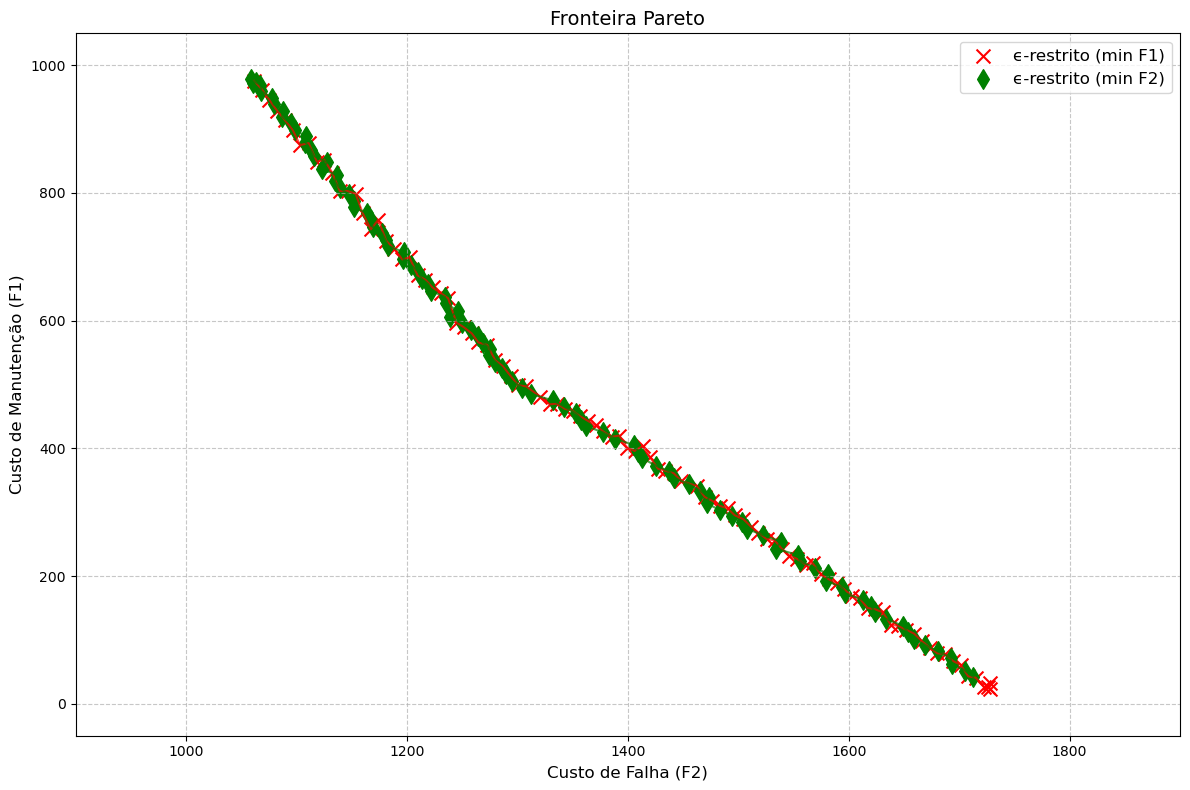

In [33]:
def plotar_resultados_comparativos(dados, num_pontos=20, max_iteracoes=100):
    #print("\nGerando fronteira com Soma Ponderada...")
    #f1_pw, f2_pw, _ = gerar_fronteira_pareto(dados, num_pontos, max_iteracoes)
    
    print("\nGerando fronteira com ϵ-restrito (min F1)...")
    f1_eps1, f2_eps1, _ = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f1')
    
    print("\nGerando fronteira com ϵ-restrito (min F2)...")
    f1_eps2, f2_eps2, _ = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f2')
    
    plt.figure(figsize=(12, 8))
    
    # ϵ-restrito (min f1) - pontos
    plt.scatter(f2_eps1, f1_eps1, c='red', marker='x', label='ϵ-restrito (min F1)', s=100)
    # ϵ-restrito (min f1) - linhas
    plt.plot(f2_eps1, f1_eps1, c='red', linestyle='-', alpha=0.7)
    
    # ϵ-restrito (min f2) - pontos
    plt.scatter(f2_eps2, f1_eps2, c='green', marker='d', label='ϵ-restrito (min F2)', s=100)
    # ϵ-restrito (min f2) - linhas
    plt.plot(f2_eps2, f1_eps2, c='green', linestyle='-', alpha=0.7)
    
    plt.title("Fronteira Pareto", fontsize=14)
    plt.xlabel("Custo de Falha (F2)", fontsize=12)
    plt.ylabel("Custo de Manutenção (F1)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    plt.xlim(900, 1900)
    plt.ylim(-50, 1050)
    
    plt.tight_layout()
    plt.show()


# Execução principal
if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)
    plotar_resultados_comparativos(dados, num_pontos=100, max_iteracoes=1000)